In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import category_encoders as ce
from geopy.distance import geodesic
from geopy import distance
import re

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import time


In [2]:
# # def tokenezation(text):
# #     word_tokens = word_tokenize(text)
# #     return word_tokens

# def filter_stop_words(text):
#     tokens = word_tokenize(text)
#     filtered_tokens = [word for word in tokens if not word in stopwords.words('english')]
#     return filtered_tokens

# def get_lemmatize(text):
#     lemmatizer = WordNetLemmatizer()
#     tokens = word_tokenize(text)
#     lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
#     return lemmatized_words

# def get(text):
#     sia = SentimentIntensityAnalyzer()
#     return (sia.polarity_scores(text))

# # df['negative_review'] = df['negative_review'].apply(tokenezation)
# df['negative_review'] = df['negative_review'].apply(filter_stop_words)
# df['negative_review'] = df['negative_review'].apply(get_lemmatize)
# df['negative_review'] = df['negative_review'].apply(get)

In [3]:
pd.set_option('display.max_columns', None)

RANDOM_SEED = 42

!pip freeze > requirements.txt

df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [5]:
# Для того, чтобы заполнить данные в пропущенных значениях, создадим два признака из адреса отеля - страну и город.

# Функция для получения признака "Страна"
def get_country(address):
    country = address.split(' ')[-2:]
    country = str(country).replace(',', '').replace("['", "").replace("']", "").replace("'", "")
    if country == 'United Kingdom':
        return 'United Kingdom'
    if country == 'Paris France':
        return 'France'
    if country == 'Amsterdam Netherlands':
        return 'Netherlands'
    if country == 'Milan Italy':
        return 'Italy'
    if country == 'Vienna Austria':
        return 'Austria'
    if country == 'Barcelona Spain':
        return 'Spain'
    else:
        return 'other'
    
df['country'] = df['hotel_address'].apply(get_country)

# Функция для получения признака "Город"
def city(country):
    if country == 'United Kingdom':
        return 'London'
    if country == 'France':
        return 'Paris'
    if country == 'Netherlands':
        return 'Amsterdam'
    if country == 'Italy':
        return 'Milan'
    if country == 'Austria':
        return 'Vienna'
    if country == 'Spain':
        return 'Barcelona'

df['city'] = df['country'].apply(city)

In [4]:
# Объединив датасеты для обучения и предсказания, видим пропуски в двух столбцах: с широтой (lat) и долготой (lng) расположения отеля. 

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [6]:
# Так как уникальных значений стран в наших данных немного, 
# восстановлю данные о координатах модальным значениями по стране (а значит по городу, в к-м расположен отель,
# так как отели из нашей выборки расположены все в столицах)

# Сгруппирую данные для получения нужныз модальных значений
df.groupby(['country'])['lng'].agg(pd.Series.mode)
df.groupby(['country'])['lat'].agg(pd.Series.mode)

country
Austria           48.214662
France            48.879484
Italy             45.533137
Netherlands       52.370545
Spain             41.371308
United Kingdom    51.501910
Name: lat, dtype: float64

In [7]:
# Заполню пропуски полученными на предыдущем шаге данными 
df[df['country'] == 'Austria'] = df[df['country'] == 'Austria'].fillna({'lng':16.362799, 'lat':48.214662})
df[df['country'] == 'France'] = df[df['country'] == 'France'].fillna({'lng':2.355654, 'lat':48.879484})
df[df['country'] == 'Italy'] = df[df['country'] == 'Italy'].fillna({'lng':9.171102, 'lat':45.533137})
df[df['country'] == 'Netherlands'] = df[df['country'] == 'Netherlands'].fillna({'lng':4.888644, 'lat':52.370545})
df[df['country'] == 'Spain'] = df[df['country'] == 'Spain'].fillna({'lng':2.181698, 'lat':41.371308})
df[df['country'] == 'United Kingdom'] = df[df['country'] == 'United Kingdom'].fillna({'lng':-0.023221, 'lat':51.501910})

In [8]:
# Создаю: 1) признак с координатами отеля;   
# 2) признак с координатами центра города (за центр города я брала координаты с Google Maps, по точке в центре города)

def get_coordinate(lat, lng):
    return (float(lat), float(lng))

def capital_coordinate(country):
    if country == 'United Kingdom':
        return (float(51.50936092785646), float(-0.12416095345639586))
    if country == 'France':
        return (float(48.853229), float(2.342797))
    if country == 'Netherlands':
        return (float(52.37176471692262), float(4.895930820099642))
    if country == 'Italy':
        return (float(45.46986), float(9.18499))
    if country == 'Austria':
        return (float(48.20471741160276), float(16.37049992180316))
    if country == 'Spain':
        return (float(41.395704279217775), float(2.172020436193314))
        

df['hotel_coordinate'] = df.apply(lambda row: get_coordinate(row['lat'], row['lng']), axis = 1)
df['center_coordinate'] = df['country'].apply(capital_coordinate)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [11]:
alpha = 0.05
result = stats.levene(df['total_number_of_reviews'], df['additional_number_of_scoring'])
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')


p-value = 0.000
Дисперсии не одинаковы, нужно использовать непараметрический тест


In [12]:
df[cat_cols]

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review,country,city,hotel_coordinate,center_coordinate
0,Via Senigallia 6 20161 Milan Italy,7/21/2017,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,Italy,Milan,"(45.5331372, 9.1711019)","(45.46986, 9.18499)"
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,12/12/2016,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,No Positive,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,Netherlands,Amsterdam,"(52.3856494, 4.834443)","(52.37176471692262, 4.895930820099642)"
2,Mallorca 251 Eixample 08008 Barcelona Spain,11/26/2015,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,Nice welcoming and service,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,Spain,Barcelona,"(41.3931918, 2.16152)","(41.395704279217775, 2.172020436193314)"
3,Piazza Della Repubblica 17 Central Station 201...,10/17/2015,Hotel Principe Di Savoia,United States of America,No Negative,Everything including the nice upgrade The Hot...,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,Italy,Milan,"(45.479888, 9.1962982)","(45.46986, 9.18499)"
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,5/16/2016,Hotel Esther a,United Kingdom,No Negative,Lovely hotel v welcoming staff,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,Netherlands,Amsterdam,"(52.3705447, 4.8886439)","(52.37176471692262, 4.895930820099642)"
...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,4/19/2017,Hotel Moonlight,France,No Negative,Tr s proche du metro Earl s court,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,United Kingdom,London,"(51.4940285, -0.1910497)","(51.50936092785646, -0.12416095345639586)"
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,2/13/2017,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,The bed was so comfy I stayed with my boyfrie...,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,Austria,Vienna,"(48.1923791, 16.3994512)","(48.20471741160276, 16.37049992180316)"
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,2/7/2016,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,great location simple check in out nice shower,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,United Kingdom,London,"(51.5207945, -0.1310845)","(51.50936092785646, -0.12416095345639586)"
515736,31 Great Cumberland Place Westminster Borough ...,5/21/2017,The Marble Arch London,United Arab Emirates,No Negative,Location and very comfy bed,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,United Kingdom,London,"(51.5151247, -0.1600656)","(51.50936092785646, -0.12416095345639586)"


<AxesSubplot: >

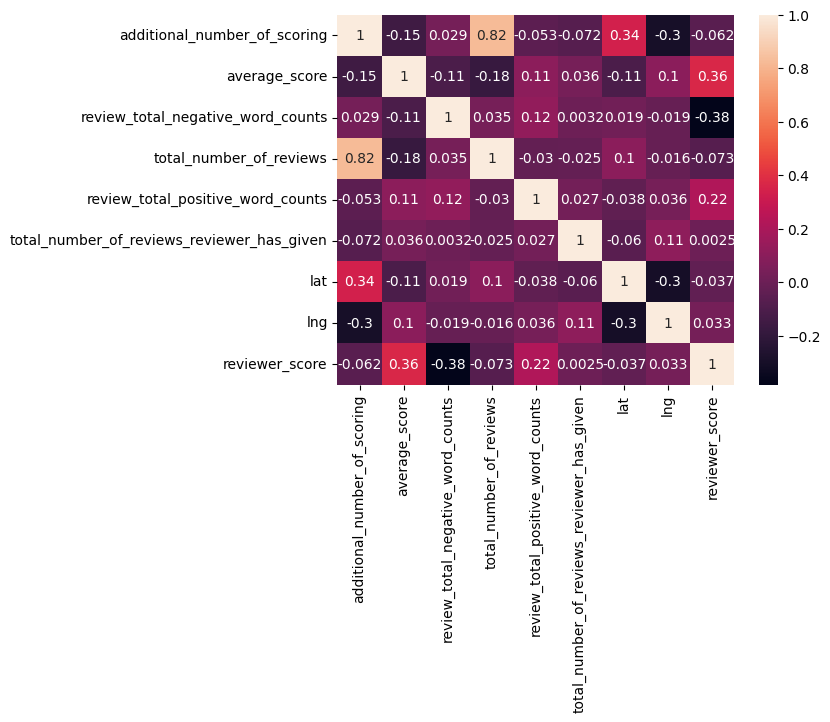

In [13]:
sns.heatmap(df.corr(), annot = True)

Анализирую матрицу корреляции числовых признаков мы видем сильную зависимость между признаками "additional_number_of_scoring" и "total_number_of_reviews". От одного из этих признаков нам необходимо избавиться. 
оставим признак, который имеет бОльшую взаимосвязь с целевой переменной.
Исходя из корреляции по методу Пирсона, следует избавиться от "additional_number_of_scoring", так как взаимосвязь "total_number_of_reviews" и 'reviewer_score' проявляется больше.
Однако, проверим нормальность распределения двух этих признаков.

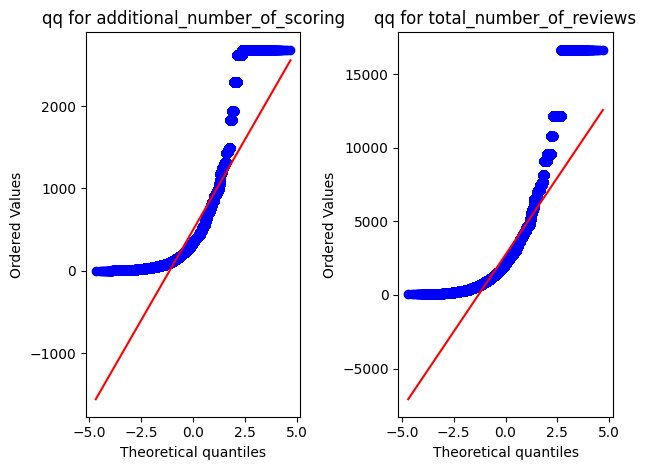

In [14]:
# Построим qq plot графики для двух признаков, чтобы оценить нормальность их распределения.

plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(df['additional_number_of_scoring'], plot=plt) # qq plot
plt.title('qq for additional_number_of_scoring')

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
stats.probplot(df['total_number_of_reviews'], plot=plt) # qq plot
plt.title('qq for total_number_of_reviews')

plt.tight_layout() 
plt.show() 

<AxesSubplot: >

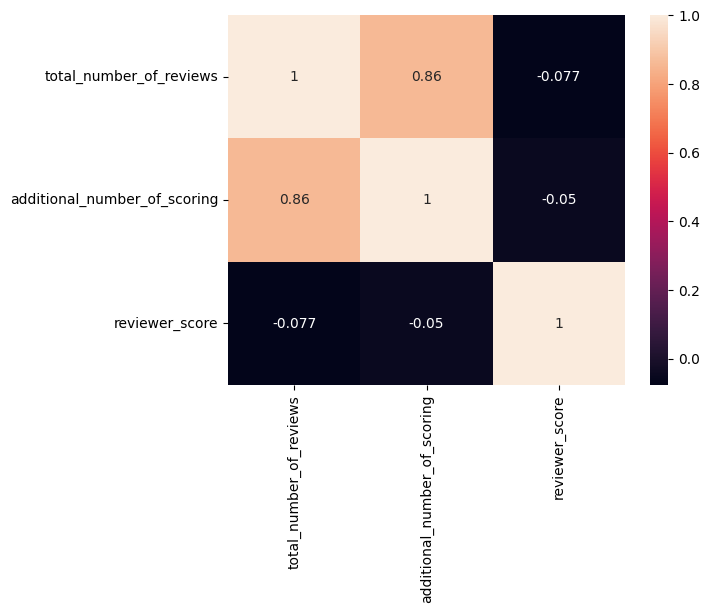

In [15]:
# Исходя из qq plot графиков выше, можно сказать, что показатели распределены ненормально. 
# Оценим взаимосвязь этих признаков с целевой переменной, использую метод Спирмена.

sns.heatmap(df[['total_number_of_reviews', 'additional_number_of_scoring', 'reviewer_score']].corr(method = 'spearman'), annot = True)


In [99]:
# Взаимосвязь признаков "total_number_of_reviews" и 'reviewer_score' при данном методе корреляции видна еще сильнее.
# Следовательно, удалим признак "additional_number_of_scoring".

# df = df.drop("additional_number_of_scoring", axis = 1)

In [100]:
feature_df =feature_df.drop("additional_number_of_scoring", axis = 1)

In [18]:
def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = str(num_tags.strip().lower().split(' \', \' '))
    return res

df['tags_n'] = df['tags'].apply(rev_func)

# df = df.explode('tags_n')

In [19]:
df['tags']

0         [' Leisure trip ', ' Couple ', ' Double Room '...
1         [' Leisure trip ', ' Group ', ' Triple Room ',...
2         [' Business trip ', ' Solo traveler ', ' Twin ...
3         [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4         [' Business trip ', ' Solo traveler ', ' Class...
                                ...                        
515733    [' Leisure trip ', ' Group ', ' Club Double or...
515734    [' Leisure trip ', ' Couple ', ' Standard Doub...
515735    [' Business trip ', ' Solo traveler ', ' Singl...
515736    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
515737    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 515738, dtype: object

In [21]:
# Из признака даты получим два новых признака - год и месяц. Так же создадаим признак сезона.

df['review_date'] = pd.to_datetime(df['review_date'])
df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month


def get_season(data):
    if data in [12, 1, 2]:
        return 'winter'
    if data in [3, 4, 5]:
        return 'spring'
    if data in [6, 7, 8]:
        return 'summer'
    if data in [9, 10, 11]:
        return 'autumn'
    
df['season'] = df['month'].apply(get_season)



In [22]:

df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x.strip())
df['reviewer_nationality'].unique()





array(['United Kingdom', 'Belgium', 'Sweden', 'United States of America',
       'Ecuador', 'Netherlands', 'Ireland', 'Canada', 'Norway',
       'Bulgaria', 'Italy', 'Australia', 'Seychelles', 'Kuwait',
       'Saudi Arabia', 'Czech Republic', 'France', 'Germany',
       'South Africa', 'United Arab Emirates', 'Greece', 'Spain',
       'Switzerland', 'Macedonia', 'Poland', 'Bahrain', 'Qatar', 'India',
       'Singapore', 'Malaysia', 'Thailand', 'Brazil', 'Crimea', 'Turkey',
       'Israel', '', 'Lebanon', 'Romania', 'Cyprus', 'Portugal',
       'Slovakia', 'Jersey', 'Gibraltar', 'Austria', 'Kenya',
       'Isle of Man', 'Costa Rica', 'Oman', 'Hungary', 'Iceland',
       'Estonia', 'Hong Kong', 'China', 'Malta', 'Pakistan', 'Montenegro',
       'Slovenia', 'South Korea', 'Ukraine', 'Japan', 'Azerbaijan',
       'Russia', 'Brunei', 'Cayman Islands', 'Serbia', 'Argentina',
       'Denmark', 'Egypt', 'Finland', 'Mexico', 'Taiwan', 'Peru',
       'Philippines', 'New Zealand', 'Luxembourg', 

In [23]:
# Преобразуем признак 'days_since_review', оставив только число.

df['days_since_review'] = df['days_since_review'].apply(lambda x: str(x.split(' ')[:1]).replace("'", '').replace("'", '').replace('[', '').replace(']', ''))
df['days_since_review'] = df['days_since_review'].astype('float64')
                                                         

In [24]:
# df['tags'] = df['tags'].apply(lambda x: x.replace("' ", "'").replace(" '", "'").replace("[", "").replace("]", "").split(','))

# Мне хотелось обработать тэги, а так же вычленить полезную информацию из негативных и положительных отзывов, 
# но к сожалению, я не смогла придумать как.

In [25]:
# Создаю признак с расстоянием от центра города до отеля 

from geopy import distance

def dist_from_cent(hotel_coordinate, center_coordinate):
    return geodesic(hotel_coordinate, center_coordinate).kilometers

df['dist_from_cent_km'] = round(df.apply(lambda row: dist_from_cent(row['hotel_coordinate'], row['center_coordinate']),  axis = 1))

In [27]:
# Чтото пошло не так с попыткой нормализовать признаки:

# col_names = ['days_since_review', 'additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given']

# from sklearn import preprocessing
# r_scaler = preprocessing.RobustScaler()

# r_scaler = preprocessing.RobustScaler()
# df_r = r_scaler.fit_transform(feature_df)

# df_r = pd.DataFrame(df_r, columns=col_names)

# fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
# ax1.set_title('Распределения после RobustScaler')

# sns.kdeplot(df_r)


In [26]:
df = df.drop('center_coordinate', axis = 1)
df = df.drop('hotel_coordinate', axis = 1)

In [59]:
train_data = feature_df[feature_df['reviewer_score'].isnull() == False]
test_data = feature_df[feature_df['reviewer_score'].isnull() == True]

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))



MAPE: 0.13623416832536273


In [101]:
train_data = feature_df[feature_df['reviewer_score'].isnull() == False]
test_data = feature_df[feature_df['reviewer_score'].isnull() == True]

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

In [98]:
feature_df.corr(method = 'spearman')

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,year,month,dist_from_cent_km,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,season_summer,season_winter,season_autumn,season_spring
additional_number_of_scoring,1.000000,-0.128241,0.049094,0.859014,-0.056850,-0.105376,0.022983,-0.049534,-0.012601,-0.017141,0.221718,-0.008694,-0.058304,-0.100898,-0.125864,-0.107203,-0.159034,-0.114065,0.175660,-0.147667,0.089226,-0.198812,0.508111,-0.389866,-0.208492,-0.032597,0.039402,-0.011161,0.006165
average_score,-0.128241,1.000000,-0.158579,-0.193501,0.139149,0.040756,-0.014095,0.356856,0.014767,-0.008845,-0.254018,-0.004201,-0.013857,0.001076,-0.007850,0.001583,0.032362,-0.016161,-0.038801,0.008275,-0.007761,0.071518,-0.088613,0.007495,0.072822,0.002241,0.007201,-0.011781,0.002215
review_total_negative_word_counts,0.049094,-0.158579,1.000000,0.051824,0.022837,0.007960,-0.045261,-0.470300,0.041265,-0.009898,0.061431,-0.004650,-0.019823,-0.018009,-0.004109,-0.023043,-0.016889,-0.006084,0.012721,-0.018421,0.009600,-0.010913,0.042837,-0.033196,-0.020907,0.010877,-0.018339,-0.009492,0.015919
total_number_of_reviews,0.859014,-0.193501,0.051824,1.000000,-0.039901,-0.038596,0.021496,-0.076538,-0.016968,-0.003652,0.128840,-0.004453,-0.007984,-0.016676,-0.033065,-0.033817,-0.060847,-0.019621,0.068100,0.036432,0.150967,-0.027090,0.116231,-0.322275,-0.011250,-0.008232,0.012136,-0.003057,-0.000336
review_total_positive_word_counts,-0.056850,0.139149,0.022837,-0.039901,1.000000,0.047334,-0.017829,0.311376,0.024354,-0.024121,-0.027573,-0.005897,-0.023324,-0.027003,-0.039005,-0.023943,-0.003172,-0.045874,-0.018024,0.004622,0.030185,0.031755,-0.060465,0.013079,0.019562,0.021334,-0.006760,-0.030749,0.014689
total_number_of_reviews_reviewer_has_given,-0.105376,0.040756,0.007960,-0.038596,0.047334,1.000000,0.036594,-0.026483,-0.038682,0.020865,-0.060708,-0.001709,0.060348,0.117880,0.156675,0.155457,0.114690,0.184338,-0.125179,0.100367,-0.020045,0.010080,-0.114227,0.024444,0.099789,-0.004995,-0.001005,0.016765,-0.010281
days_since_review,0.022983,-0.014095,-0.045261,0.021496,-0.017829,0.036594,1.000000,-0.005332,-0.911589,0.202993,-0.015181,0.000687,-0.005267,-0.004694,-0.002847,0.002338,-0.009957,-0.001168,0.010215,-0.009447,-0.020685,-0.003878,0.007508,0.010384,0.011748,-0.147249,0.046678,0.274922,-0.162727
reviewer_score,-0.049534,0.356856,-0.470300,-0.076538,0.311376,-0.026483,-0.005332,1.000000,0.017323,-0.032851,-0.101763,-0.005273,-0.028605,-0.030539,-0.080544,-0.042709,-0.027370,-0.072881,0.016385,-0.009889,0.008943,0.035049,-0.039634,0.008247,0.021465,-0.005678,0.030821,-0.035794,0.010923
year,-0.012601,0.014767,0.041265,-0.016968,0.024354,-0.038682,-0.911589,0.017323,1.000000,-0.583933,0.015256,-0.003031,0.000151,0.001258,-0.001587,-0.016832,-0.007478,0.000303,0.011335,0.003747,0.022912,-0.000915,0.003195,-0.013722,-0.019194,0.079839,0.064893,-0.473243,0.317639
month,-0.017141,-0.008845,-0.009898,-0.003652,-0.024121,0.020865,0.202993,-0.032851,-0.583933,1.000000,-0.006271,0.005915,0.010348,0.007150,0.010470,0.036804,0.039297,0.002314,-0.049309,0.009672,-0.015035,0.009808,-0.022683,0.013618,0.022887,0.102563,-0.250247,0.590398,-0.439794


In [55]:
# Посмотрим на категориальные и числовые признаки

cat_cols = []
num_cols = []

for col in feature_df.columns:
    if feature_df[col].dtypes == 'object':
        cat_cols.append(col)
    else:
        num_cols.append(col)
        
print('Категориальные признаки:', cat_cols)
print('Числовые признаки', num_cols)

Категориальные признаки: []
Числовые признаки ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'reviewer_score', 'year', 'month', 'dist_from_cent_km', 'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5', 'reviewer_nationality_6', 'reviewer_nationality_7', 'country_Italy', 'country_Netherlands', 'country_Spain', 'country_United Kingdom', 'country_France', 'country_Austria', 'season_summer', 'season_winter', 'season_autumn', 'season_spring']


In [36]:
df['hotel_name'].nunique()

1492

In [37]:
feature_df = df.copy()
feature_df = feature_df.drop(['hotel_address', 'review_date', 'negative_review', 'positive_review', 'tags', 'lat', 'lng', 'tags_n'], axis = 1)

In [90]:
# feature_df = feature_df.drop(['country', 'season', 'reviewer_nationality'], axis = 1)
# feature_df = feature_df.drop('city', axis = 1)
feature_df
cat_cols = feature_df.columns.to_list()
del cat_cols[:7]
del cat_cols[1:4]
cat_cols

['reviewer_score',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7',
 'country_Italy',
 'country_Netherlands',
 'country_Spain',
 'country_United Kingdom',
 'country_France',
 'country_Austria',
 'season_summer',
 'season_winter',
 'season_autumn',
 'season_spring']

In [91]:
feature_df[cat_cols].corr(method = 'spearman')

,reviewer_score,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,season_summer,season_winter,season_autumn,season_spring
reviewer_score,1.000000,-0.005273,-0.028605,-0.030539,-0.080544,-0.042709,-0.027370,-0.072881,0.016385,-0.009889,0.008943,0.035049,-0.039634,0.008247,0.021465,-0.005678,0.030821,-0.035794,0.010923
reviewer_nationality_0,-0.005273,1.000000,0.008936,0.023691,0.022013,0.037366,0.006114,0.028005,-0.011818,0.001809,-0.000552,0.001361,-0.009681,0.012488,0.000403,0.003350,-0.005754,0.006563,-0.004274
reviewer_nationality_1,-0.028605,0.008936,1.000000,0.028105,0.050477,0.164500,0.085175,0.147857,-0.049433,0.044934,0.006753,0.014120,-0.092117,0.035561,0.061987,0.009011,-0.013555,0.011078,-0.006933
reviewer_nationality_2,-0.030539,0.023691,0.028105,1.000000,0.210825,0.099617,0.128080,0.251828,-0.196189,0.083918,0.012702,0.019149,-0.150053,0.023387,0.135025,0.000080,0.005104,0.002304,-0.007299
reviewer_nationality_3,-0.080544,0.022013,0.050477,0.210825,1.000000,0.143090,0.244342,0.248085,-0.201380,0.109144,0.003090,0.037885,-0.175868,0.057054,0.106997,0.008605,-0.004456,-0.000511,-0.004026
reviewer_nationality_4,-0.042709,0.037366,0.164500,0.099617,0.143090,1.000000,0.274694,0.231301,-0.309914,0.095018,-0.001837,0.024991,-0.147488,0.067914,0.075477,0.045025,-0.047021,0.028932,-0.028934
reviewer_nationality_5,-0.027370,0.006114,0.085175,0.128080,0.244342,0.274694,1.000000,0.277907,-0.537940,0.113056,0.030112,0.062852,-0.228034,0.108712,0.076764,0.054932,-0.054654,0.025389,-0.028246
reviewer_nationality_6,-0.072881,0.028005,0.147857,0.251828,0.248085,0.231301,0.277907,1.000000,-0.196586,0.103327,0.049557,0.048319,-0.185575,0.046671,0.075745,-0.012732,0.007442,0.005069,0.000913
reviewer_nationality_7,0.016385,-0.011818,-0.049433,-0.196189,-0.201380,-0.309914,-0.537940,-0.196586,1.000000,-0.093462,-0.036167,-0.071212,0.240104,-0.106048,-0.104668,-0.066061,0.064997,-0.030556,0.034699
country_Italy,-0.009889,0.001809,0.044934,0.083918,0.109144,0.095018,0.113056,0.103327,-0.093462,1.000000,-0.098498,-0.101318,-0.283676,-0.101107,-0.079686,0.025600,-0.035520,0.007510,0.000837


In [43]:
import scipy.stats as stats
import pandas as pd

# задаём уровень значимости
alpha = 0.05 

# вычисляем таблицу сопряжённости
table = pd.crosstab(feature_df['country'], feature_df['city'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


In [45]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(df['reviewer_nationality'])
feature_df = pd.concat([feature_df, type_bin], axis=1)

import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True)
type_bin = encoder.fit_transform(df['country'])
feature_df = pd.concat([feature_df, type_bin], axis=1)


season_encoder = ce.OneHotEncoder(cols=['season'], use_cat_names=True) 
season_bin = season_encoder.fit_transform(df['season'])
feature_df = pd.concat([feature_df, season_bin], axis=1)

In [50]:
feature_df = feature_df.drop('hotel_name', axis = 1)
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(df['hotel_name'])
clothing = pd.concat([feature_df, type_bin], axis=1)

In [58]:
# train_data = feature_df[feature_df['reviewer_score'].isnull() == False]
# test_data = feature_df[feature_df['reviewer_score'].isnull() == True]

# y = train_data.reviewer_score.values            # наш таргет
# X = train_data.drop(['reviewer_score'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# # Импортируем необходимые библиотеки:
# from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
# from sklearn import metrics # инструменты для оценки точности модели

# # Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
# model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# # Обучаем модель на тестовом наборе данных
# model.fit(X_train, y_train)

# # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# # Предсказанные значения записываем в переменную y_pred
# y_pred = model.predict(X_test)

# # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s


MAPE: 0.9455609846015678


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.2s finished
